In [2]:
import math
import collections

from scipy import signal
from scipy.fft import fft, fftfreq

import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# IMPORT Ole's fixed TMSiSDK python interfacwe- may change
sys.path.insert(0, 'C:/Projects/tmsi-python-interface')
from TMSiSDK.file_readers import Poly5Reader
sys.path.insert(0, '../rsemg')
import helper_functions as hf

C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [3]:
def notch_filter(sample, sample_frequ, freq_to_pull, quality_factor_q):
    """
    This is a filter designed to take out a specific frequency. 
    In the EU in some data electrical cords can interfere at around 50 herts.
    In some other locations the interference is at 60 Hertz. The specificities 
    of a local power grid may neccesitate notch filtering. 

    
    """
    # create notch filter
    samp_freq = sample_frequ # Sample frequency (Hz)
    notch_freq = freq_to_pull # Frequency to be removed from signal (Hz)
    quality_factor = quality_factor_q # Quality factor

    # design a notch filter using signal.iirnotch
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)

    # compute magnitude response of the designed filter
    freq, h = signal.freqz(b_notch, a_notch, fs=samp_freq)
    # make the output signal
    output_signal = signal.filtfilt(b_notch, a_notch, sample)
    return output_signal


In [4]:
file_chosen = os.path.join('../not_pushed','topspin_data_anonymized','M002','004','EMG_recording'+'.Poly5')
#C:\Projects\rsemg\not_pushed\topspin_data_anonymized\M002\004
data_emg = Poly5Reader(file_chosen)

Reading file  ../not_pushed\topspin_data_anonymized\M002\004\EMG_recording.Poly5
	 Number of samples:  766560 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


In [5]:
not_filtered = data_emg.samples

In [6]:
filtered = notch_filter(data_emg.samples, 2048, 50, 30)

In [7]:
not_filtered

array([[  307.57369995,   312.21539307,   309.24713135, ...,
            0.        ,     0.        ,     0.        ],
       [ 4776.70019531,  4775.00195312,  4776.56591797, ...,
            0.        ,     0.        ,     0.        ],
       [11576.36328125, 11578.5       , 11576.75390625, ...,
            0.        ,     0.        ,     0.        ]])

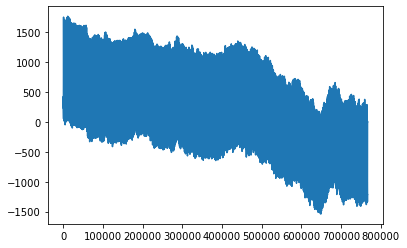

In [8]:
plt.plot(not_filtered[0])
plt.show()

In [9]:
def bnotch_filter(sample, sample_frequ, freq_to_pull, quality_factor_q):
    """
    This is a filter designed to take out a specific frequency. 
    In the EU in some data electrical cords can interfere at around 50 herts.
    In some other locations the interference is at 60 Hertz. The specificities 
    of a local power grid may neccesitate notch filtering. 
    
    :param sample: percentage variation tolerance to allow without cutting automatically
    :type sample: :class:  int
    :param sample_frequ: the frequency at which the sample was captured, often 2048
    :type sample_frequ: :class:  int
    :param freq_to_pull: the frequency you desire to remove from teh signal
    :type freq_to_pull: :class:  int
    :param quality_factor_q: how high the quality of the removal is
    :type quality_factor_q: :class:  int

    :return sample_cut: the filterered sample data
    :rtype: :class: `~numpy.ndarray`

    """
    # create notch filter
    # design a notch filter using signal.iirnotch
    b_notch, a_notch = signal.iirnotch(freq_to_pull, quality_factor_q, sample_frequ)
    
    # make the output signal
    output_signal = signal.filtfilt(b_notch, a_notch, sample)
    return output_signal

In [10]:
filteredb = bnotch_filter(data_emg.samples, 2048, 50, 30)

In [12]:
filteredb 

array([[ 3.09138638e+02,  3.13879640e+02,  3.10972018e+02, ...,
         7.94370089e+00,  6.96542314e+00,  5.82379503e+00],
       [ 4.77679274e+03,  4.77512456e+03,  4.77671581e+03, ...,
        -2.75666003e+01, -2.39617396e+01, -1.97949697e+01],
       [ 1.15767694e+04,  1.15788837e+04,  1.15771061e+04, ...,
        -6.48153131e+01, -5.64563991e+01, -4.67735493e+01]])

In [13]:
filteredc = hf.emg_bandpass_butter_sample(filteredb, 5, 450, 2048, output='sos')

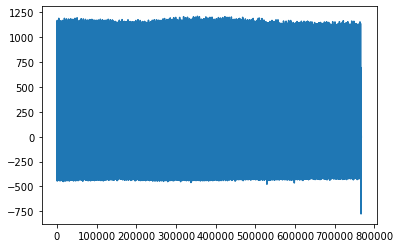

In [14]:
plt.plot(filteredc[0])
plt.show()

In [21]:
def show_my_power_spectrum(sample, sample_rate):
    N = len(sample)
    # for our emgs samplerate is usually 2048
    yf = fft((sample))
    xf = fftfreq(N, 1 / sample_rate)

    plt.plot(xf, np.abs(yf))

    plt.show()

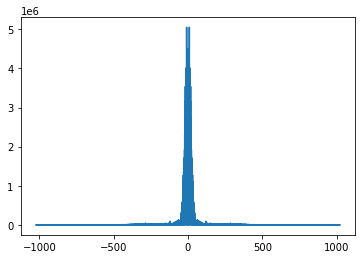

In [22]:
show_my_power_spectrum(filteredc[0], 2048)

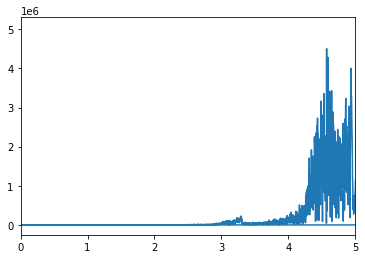

In [26]:
hf.show_my_power_spectrum(filteredc[0], 2048, 5)

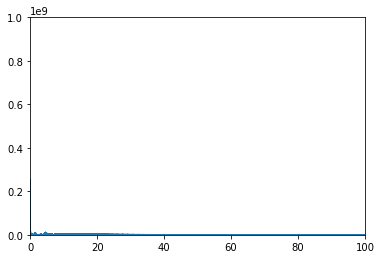

In [59]:
show_my_power_spectrum(data_emg.samples[0], 2048)

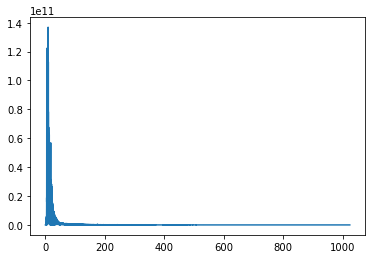

In [29]:
sampling_rate = 2048
data = filteredc[1]

time_of_sample = len(data)/sampling_rate

time = np.arange(0, time_of_sample, 1/sampling_rate)



fourier_transform = np.fft.rfft(data)

abs_fourier_transform = np.abs(fourier_transform)

power_spectrum = np.square(abs_fourier_transform)

frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))

plt.plot(frequency, power_spectrum)
plt.show()

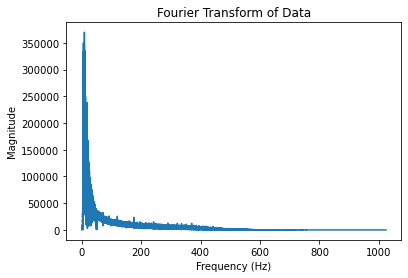

In [31]:
from scipy.fft import rfft, rfftfreq, irfft

sample_FT = rfft(data)
freq = rfftfreq(int(time_of_sample * sampling_rate), 1 / sampling_rate)
plt.title("Fourier Transform of Data")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.plot(freq, np.abs(sample_FT))